
# Instrumental Variables

When examining the impact of a treatment A on an outcome Y, our goal is to ascertain the treatment's effect. However, this analysis is often complicated by the presence of indirect pathways that are challenging to account for completely.

In cases where we cannot introduce randomness ourselves, we search for a natural source of randomness through instrumental variables that either lacks indirect pathways or possesses ones that can be mitigated through control measures.


In [1]:
import os
import requests

def download_from_url(url, filename, overwrite=False):
    if os.path.exists(filename) and not overwrite:
        return
        
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

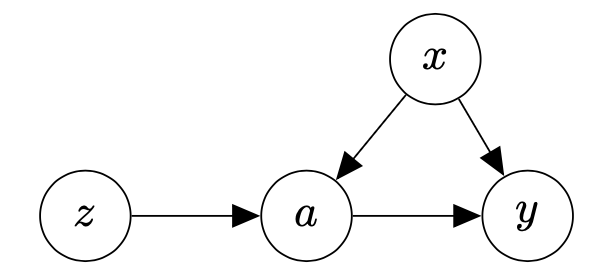

In [3]:
from IPython.display import Image

download_from_url('https://nyu.box.com/shared/static/gwhwi3vbimw2uyyhw0ltwp0o1tknc36z.png', 'instrument_variable.png')
Image('instrument_variable.png')

Contrary to controlling for a variable, where we exclude parts of the analysis that can be explained by the control variable to eliminate indirect pathways, using an instrumental variable focuses on retaining only the effects directly linked to the instrument. This method ensures that the relationship examined is free from hidden biases, providing a clearer understanding of the treatment's impact.

In [5]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

## Example: Effect of smoking cigarettes during pregnancy on the infant birth weight

### Part I: Understanding the data

Notation:

$A:$ number of cigarettes smoked per day during pregnancy

$Y$: Child birthweight

$X$: Socioeconomic status as a confounder

$Z$: State taxes on tobacco as our instrument variable

\begin{align}
X &\leftarrow \epsilon_x  \\
Z &\leftarrow \epsilon_z \\
A &\leftarrow \gamma X + \psi z + \epsilon_a \\
Y & \leftarrow \alpha A + \beta X + \epsilon_y
\end{align}

In [6]:
random_seed = np.random.randint(0, 10000)
df_array = []

def generate_data(current_seed):
  np.random.seed(random_seed + current_seed)
  N = 2000 # Number of examples
  X = np.random.normal(0, 1, N)  # Socioeconomic status, acting as a hidden confounder
  Z = np.random.normal(0, 1, N)  # State taxes on tobacco, our instrument

  z_to_a = -2
  x_to_a = 1
  a_to_y = -2
  x_to_y = 2

  # Generate endogenous variable (A) affected by Z
  A = (z_to_a * Z) + (x_to_a * X) + np.random.normal(0, 1, N)

  # Generate outcome variable (Y) affected by A and X
  Y = (a_to_y * A) + (x_to_y * X) + np.random.normal(0, 1, N)

  # Create DataFrame
  df_array.append(pd.DataFrame({'A': A, 'Y': Y, 'Z': Z, 'X': X}))

In [7]:
num_datasets = 100
for dataset_seed in range(num_datasets):
  generate_data(dataset_seed)

df_array[0].head()

,A,Y,Z,X
0,1.334707,-3.988159,-0.223641,-0.638813
1,-3.340001,8.172015,0.922592,-0.496866
2,1.812776,-2.475226,-1.234224,-0.673137
3,5.226509,-6.350220,-1.343042,1.925146
4,0.991726,1.755226,-0.143973,0.493478


### Part II: Standard Linear regression

We optimize the following objective

\begin{equation}
\min_{\widehat{\alpha}} \sum_{i=1}^n\left(y_i - \widehat{\alpha} a_i \right)^2
\end{equation}

In [8]:
wo_instrument_ols = sm.OLS(df_array[0]['Y'], sm.add_constant(df_array[0]['A'])).fit()
print(wo_instrument_ols.summary())
df_array[0]['Predicted_Y'] = wo_instrument_ols.predict(sm.add_constant(df_array[0]['A']))

ols_coefficients = []
for dataset_seed in range(num_datasets):
  wo_instrument_ols = sm.OLS(df_array[dataset_seed]['Y'], sm.add_constant(df_array[dataset_seed]['A'])).fit()
  ols_coefficients.append(wo_instrument_ols.params['A'])

print(f'ols_coefficients: {np.mean(ols_coefficients)} pm {np.std(ols_coefficients)}')

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     7987.
Date:                Tue, 14 May 2024   Prob (F-statistic):               0.00
Time:                        15:48:40   Log-Likelihood:                -4270.9
No. Observations:                2000   AIC:                             8546.
Df Residuals:                    1998   BIC:                             8557.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0760      0.046      1.660      0.0


### Does $z_{\text{taxes}}$ satisfy conditions of an instrument?

In [9]:
print(f"Correlation between Z and A (taxes and # cigarettes): {df_array[0]['Z'].corr(df_array[0]['A'])}")
print(f"Correlation between Z and X (taxes and socioeconomic status): {df_array[0]['Z'].corr(df_array[0]['X'])}")

Correlation between Z and A (taxes and # cigarettes): -0.8207355990793503
Correlation between Z and X (taxes and socioeconomic status): -0.03182015864864733


### Part III: IV estimation using two-stage least squares

We run two regressions:

1. The first stage gets  $\widehat{A}$ by regressing $A$ on $Z$, fitting the parameter $\widehat{\psi}$:

\begin{equation}
\min_{\widehat{\psi}} \sum_{i=1}^n\left(a_i - \widehat{\psi} z_i \right)^2 \\
\widehat{A} = \widehat{\psi} Z
\end{equation}

2. The second stage then regresses $Y$ on $\widehat{A}$ to obtain an estimate $\widehat{\alpha}$ of the causal effect:

\begin{equation}
\min_{\widehat{\alpha}} \sum_{i=1}^n\left(y_i - \widehat{\alpha} \widehat{A_i} \right)^2 \\
\widehat{Y} = \widehat{\alpha} \widehat{A}
\end{equation}

The first stage estimates the **unconfounded component** of $A$ -- unaffected by the confounder $X$.

The second stage uses the unconfounded component $\widehat{A}$ to estimate the effect of smoking on $Y$.

In [10]:
# First Stage: Regress a_smoking on z_taxes
first_stage = sm.OLS(df_array[0]['A'], sm.add_constant(df_array[0]['Z'])).fit()
df_array[0]['A_hat'] = first_stage.predict(sm.add_constant(df_array[0]['Z']))
print(first_stage.summary())

for dataset_seed in range(num_datasets):
  first_stage = sm.OLS(df_array[dataset_seed]['A'], sm.add_constant(df_array[dataset_seed]['Z'])).fit()
  df_array[dataset_seed]['A_hat'] = first_stage.predict(sm.add_constant(df_array[dataset_seed]['Z']))

                            OLS Regression Results                            
Dep. Variable:                      A   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     4123.
Date:                Tue, 14 May 2024   Prob (F-statistic):               0.00
Time:                        15:48:48   Log-Likelihood:                -3548.4
No. Observations:                2000   AIC:                             7101.
Df Residuals:                    1998   BIC:                             7112.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0171      0.032      0.535      0.5

In [11]:
# Second Stage: Regress y_birthweight on a_smoking_hat from the first stage
second_stage = sm.OLS(df_array[0]['Y'], sm.add_constant(df_array[0]['A_hat'])).fit()
df_array[0]['Y_predictions'] = second_stage.predict(sm.add_constant(df_array[0]['A_hat']))
print(second_stage.summary())

iv_coefficients = []
for dataset_seed in range(num_datasets):
  second_stage = sm.OLS(df_array[dataset_seed]['Y'], sm.add_constant(df_array[dataset_seed]['A_hat'])).fit()
  iv_coefficients.append(second_stage.params['A_hat'])
  df_array[dataset_seed]['Y_predictions'] = second_stage.predict(sm.add_constant(df_array[dataset_seed]['A_hat']))

print(f'iv_coefficients: {np.mean(iv_coefficients)} pm {np.std(iv_coefficients)}')

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     6730.
Date:                Tue, 14 May 2024   Prob (F-statistic):               0.00
Time:                        15:48:50   Log-Likelihood:                -4405.4
No. Observations:                2000   AIC:                             8815.
Df Residuals:                    1998   BIC:                             8826.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0773      0.049      1.578      0.1

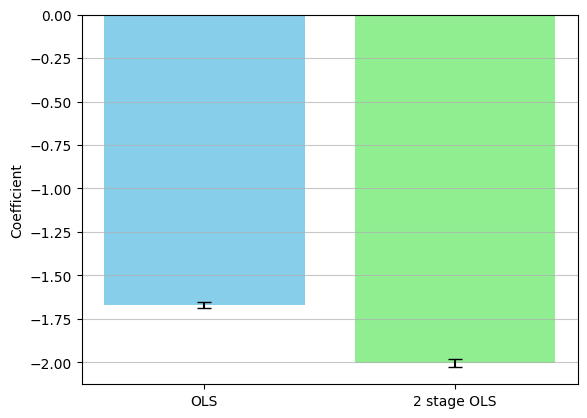

In [12]:
plt.bar(['OLS', '2 stage OLS'], [np.mean(ols_coefficients), np.mean(iv_coefficients)], \
        yerr=[np.std(ols_coefficients), np.std(iv_coefficients)], capsize=5, color=['skyblue', 'lightgreen'])
plt.ylabel('Coefficient')
plt.grid(axis='y', linestyle='-', alpha=0.7)
plt.show()


### Part IV: Identifying different response groups based on their reaction to the instrument (state taxes)
* **Compliers:** Those who smoke more when taxes are low
* **Never Takers:** Those who do not smoke regardless of tax level
* **Always Takers:** Those who smoke regardless of tax level
* **Defiers:** Those who smoke less when taxes are low (contrary to the expected direction)


In [13]:
# Note: This approach assumes binary treatment influenced by taxes above or below median
compliers = []
defiers = []
for dataset_seed in range(num_datasets):
    compliers.append(len(df_array[dataset_seed][(df_array[dataset_seed]['Z'] <= df_array[dataset_seed]['Z'].median()) & \
                                              (df_array[dataset_seed]['A'] > df_array[dataset_seed]['A'].median())]
                  ))

    defiers.append(len(df_array[dataset_seed][(df_array[dataset_seed]['Z'] > df_array[dataset_seed]['Z'].median()) & \
                                           (df_array[dataset_seed]['A'] > df_array[dataset_seed]['A'].median())]
                  ))


# Display the sizes of each group
print(f"Compliers: {np.mean(compliers)} pm {np.std(compliers)}")
print(f"Defiers: {np.mean(defiers)} pm {np.std(defiers)}")

Compliers: 803.63 pm 9.123217634146409
Defiers: 196.37 pm 9.123217634146409


## Practice data


The data set for this analysis consists of 6160 observations on males in 1979 and early 1980 from the Smoking Supplement to the 1979 National Health Interview Survey (see Mullahy (1985) for details). The dependent variable is the number of cigarettes currently smoked per day, measured in packs (i.e., the number of cigarettes smoked per day divided by 20) -- Instrumental-Variable Estimation of Count Data Models: Applications to Models of Cigarette Smoking Behavior

In [14]:
from linearmodels.datasets import birthweight
from statsmodels.api import add_constant

data = birthweight.load()
data = add_constant(data)
print(birthweight.DESCR, data.head())


J. Mullahy (1997), "Instrumental-Variable Estimation of Count Data Models:
Applications to Models of Cigarette Smoking Behavior," Review of Economics
and Statistics 79, 596-593.

faminc                   1988 family income, $1000s
cigtax                   cig. tax in home state, 1988
cigprice                 cig. price in home state, 1988
bwght                    birth weight, ounces
fatheduc                 father's yrs of educ
motheduc                 mother's yrs of educ
parity                   birth order of child
male                     =1 if male child
white                    =1 if white
cigs                     cigs smked per day while preg
lbwght                   log of bwght
bwghtlbs                 birth weight, pounds
packs                    packs smked per day while preg
faminc                   log(faminc)
    const  faminc  cigtax  cigprice  bwght  fatheduc motheduc  parity  male  \
0    1.0    13.5    16.5     122.3    109        12       12       1     1   
1    1